In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d

In [30]:
# Initial Conditions and Variables
nx  = 41
ny  = 41
nz  = 41
nt  = 10
nit = 50

vis = 0.1
rho = 1.0
Lx  = 2
Ly  = 2
Lz  = 2
dx  = Lx/(nx-1)
dy  = Ly/(ny-1)
dz  = Lz/(nz-1)
dt  = 0.01
i_dt = 1/dt
i_dx = 1/dx
i_dy = 1/dy
i_dz = 1/dz
x   = np.arange(0,Lx,dx)
y   = np.arange(0,Ly,dy)
z   = np.arange(0,Lz,dz)
u   = np.zeros((nz,ny,nx))#, dtype = np.float32 )
v   = np.zeros((nz,ny,nx))#, dtype = np.float32 )
w   = np.zeros((nz,ny,nx))#, dtype = np.float32 )
p   = np.zeros((nz,ny,nx))#, dtype = np.float32 )
un   = np.zeros((nz,ny,nx))#, dtype = np.float32 )
vn   = np.zeros((nz,ny,nx))#, dtype = np.float32 )
wn   = np.zeros((nz,ny,nx))#, dtype = np.float32 )
pn   = np.zeros((nz,ny,nx))#, dtype = np.float32 )

#b    = np.zeros((nz,ny,nx))#, dtype = np.float32 )
#uT   = np.zeros((nz,ny,nx,nt))#, dtype = np.float32 )
#vT   = np.zeros((nz,ny,nx,nt))#, dtype = np.float32 )
#wT   = np.zeros((nz,ny,nx,nt))#, dtype = np.float32 )
#pT   = np.zeros((nz,ny,nx,nt))#, dtype = np.float32 )

In [31]:
def build_b(u,v,w):
    dz2y2 = (dz*dy)**2
    dx2y2 = (dx*dy)**2
    dz2x2 = (dz*dx)**2
    dx_div = (dx2y2+dz2x2+dz2y2)

    uu = ((u[1:-1,1:-1,2:]-u[1:-1,1:-1,:-2])/dx)**2 + ((v[1:-1,2:,1:-1]-v[1:-1,:-2,1:-1])/dy)**2 + ((w[2:,1:-1,1:-1]-w[:-2,1:-1,1:-1])/dz)**2
    uv = 2*((u[1:-1,2:,1:-1]-u[1:-1,:-2,1:-1])/dy)*((v[1:-1,1:-1,2:]-v[1:-1,1:-1,:-2])/dx)
    vw = 2*((v[2:,1:-1,1:-1]-v[:-2,1:-1,1:-1])/dz)*((w[1:-1,2:,1:-1]-w[1:-1,:-2,1:-1])/dy)
    wu = 2*((w[1:-1,1:-1,2:]-w[1:-1,1:-1,:-2])/dx)*((u[2:,1:-1,1:-1]-u[:-2,1:-1,1:-1])/dz)

    tterms = 0.25*rho*((dx*dy*dz)**2)*((u[1:-1,1:-1,2:]-u[1:-1,1:-1,:-2])/dx+(v[1:-1,2:,1:-1]-v[1:-1,:-2,1:-1])/dy+(w[2:,1:-1,1:-1]-w[:-2,1:-1,1:-1])/dz)/(dx_div*dt)
    uterms = 0.125*rho*((dx*dy*dz)**2)*(uu+uv+vw+wu)/(dx_div)
    b = +tterms + uterms
    
    return b

In [32]:
def build_p(u,v,w,pn,b):
    
    dz2y2 = (dz*dy)**2
    dx2y2 = (dx*dy)**2
    dz2x2 = (dz*dx)**2
    dx_div = (dx2y2+dz2x2+dz2y2)
    
    
    
    pterms = 0.5*((pn[1:-1,1:-1,2:]+pn[1:-1,1:-1,:-2])*(dz2y2)+(pn[1:-1,2:,1:-1]+pn[1:-1,:-2,1:-1])*(dz2x2)+(pn[2:,1:-1,1:-1]+pn[:-2,1:-1,1:-1])*(dx2y2))/(dx_div)
    
    #tterms = 0.25*rho*((dx*dy*dz)**2)*((u[1:-1,1:-1,2:]-u[1:-1,1:-1,:-2])/dx+(v[1:-1,2:,1:-1]-v[1:-1,:-2,1:-1])/dy+(w[2:,1:-1,1:-1]-w[:-2,1:-1,1:-1])/dz)/(dx_div*dt)
    #uterms = 0.125*rho*((dx*dy*dz)**2)*(uu+uv+vw+wu)/(dx_div)

    p = pterms+b[1:-1,1:-1,1:-1]
    return p



In [33]:
def pressure_poisson(u,v,w,p,b):
    #print("Pressure Poisson",pn.shape)
    
    for q in range(nit):
        pn = np.copy(p)
        p[1:-1,1:-1,1:-1] = build_p(u,v,w,pn,b)
        #Apply BCs
        p[:,-1,:] = 0
        p[:,:,-1] = p[:,:,-2]
        p[:,:,0]  = p[:,:,1]
        p[:,0,:]  = p[:,1,:]
        p[0,:,:]  = p[1,:,:]
        p[-1,:,:] = p[-2,:,:]
        
        
    return p


In [34]:
def cavity_flow(nt,u,v,w,p,b,vis):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    wn = np.empty_like(w)

    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        wn = w.copy()

        #Calculating Pressure
        #print(n)
        b[1:-1,1:-1,1:-1] = build_b(un,vn,wn)
        p = pressure_poisson(un,vn,wn,p,b)
        #print(p.shape)
        #Calculating U velocity using NS
        
        pu = -1*(0.5*dt)*(p[1:-1,1:-1,2:]-p[1:-1,1:-1,:-2])/(rho*dx)
        pv = -1*(0.5*dt)*(p[1:-1,2:,1:-1]-p[1:-1,:-2,1:-1])/(rho*dy)
        pw = -1*(0.5*dt)*(p[2:,1:-1,1:-1]-p[:-2,1:-1,1:-1])/(rho*dz)
        
        uij =  un[1:-1,1:-1,1:-1]
        vij =  vn[1:-1,1:-1,1:-1]
        wij =  wn[1:-1,1:-1,1:-1]

        ui1j = un[1:-1,1:-1,2:]
        vi1j = vn[1:-1,1:-1,2:]
        wi1j = wn[1:-1,1:-1,2:]

        uin1j = un[1:-1,1:-1,:-2]
        vin1j = vn[1:-1,1:-1,:-2]
        win1j = wn[1:-1,1:-1,:-2]

        uij1 = un[1:-1,2:,1:-1]
        vij1 = vn[1:-1,2:,1:-1]
        wij1 = wn[1:-1,2:,1:-1]

        uijn1 = un[1:-1,:-2,1:-1]
        vijn1 = vn[1:-1,:-2,1:-1]
        wijn1 = wn[1:-1,:-2,1:-1]

        uik1 = un[2:,1:-1,1:-1]
        vik1 = vn[2:,1:-1,1:-1]
        wik1 = wn[2:,1:-1,1:-1]

        uikn1 = un[:-2,1:-1,1:-1]
        vikn1 = vn[:-2,1:-1,1:-1]
        wikn1 = wn[:-2,1:-1,1:-1]

        velu = -1*dt*(uij*(uij-uin1j)/dx + vij*(uij-uijn1)/dy + wij*(uij-uikn1)/dz)
        velv = -1*dt*(uij*(vij-vin1j)/dx + vij*(vij-vijn1)/dy + wij*(vij-vikn1)/dz)
        velw = -1*dt*(uij*(wij-win1j)/dx + vij*(wij-wijn1)/dy + wij*(wij-wikn1)/dz)

        visu = vis*dt*((ui1j+uin1j-2*uij)/(dx*dx) + (uij1+uijn1-2*uij)/(dy*dy) + (uik1+uikn1-2*uij)/(dz*dz))
        visv = vis*dt*((vi1j+vin1j-2*vij)/(dx*dx) + (vij1+vijn1-2*vij)/(dy*dy) + (vik1+vikn1-2*vij)/(dz*dz))
        visw = vis*dt*((wi1j+win1j-2*wij)/(dx*dx) + (wij1+wijn1-2*wij)/(dy*dy) + (wik1+wikn1-2*wij)/(dz*dz))

        #velu = -1*(un[1:-1,1:-1,1:-1]*(un[1:-1,1:-1,1:-1]-un[1:-1,1:-1,:-2])*(dt/dx)+ vn[1:-1,1:-1,1:-1]*(un[1:-1,1:-1,1:-1]-un[1:-1,:-2,1:-1])*(dt/dy) +wn[1:-1,1:-1,1:-1]*(un[1:-1,1:-1,1:-1]-un[:-2,1:-1,1:-1])*(dt/dz))
        #velv = -1*(un[1:-1,1:-1,1:-1]*(vn[1:-1,1:-1,1:-1]-vn[1:-1,1:-1,:-2])*(dt/dx)+ vn[1:-1,1:-1,1:-1]*(vn[1:-1,1:-1,1:-1]-vn[1:-1,:-2,1:-1])*(dt/dy) +wn[1:-1,1:-1,1:-1]*(vn[1:-1,1:-1,1:-1]-vn[:-2,1:-1,1:-1])*(dt/dz))
        #velw = -1*(un[1:-1,1:-1,1:-1]*(wn[1:-1,1:-1,1:-1]-wn[1:-1,1:-1,:-2])*(dt/dx)+ vn[1:-1,1:-1,1:-1]*(wn[1:-1,1:-1,1:-1]-wn[1:-1,:-2,1:-1])*(dt/dy) +wn[1:-1,1:-1,1:-1]*(wn[1:-1,1:-1,1:-1]-wn[:-2,1:-1,1:-1])*(dt/dz))
        
        #visu = (vis)*dt*((un[1:-1,1:-1,2:]+un[1:-1,1:-1,:-2]-2*un[1:-1,1:-1,1:-1])/(dx*dx)+(un[1:-1,2:,1:-1]+un[1:-1,:-2,1:-1]-2*un[1:-1,1:-1,1:-1])/(dy*dy)+(un[2:,1:-1,1:-1]+un[:-2,1:-1,1:-1]-2*un[1:-1,1:-1,1:-1])/(dz*dz))
        #visv = (vis)*dt*((vn[1:-1,1:-1,2:]+vn[1:-1,1:-1,:-2]-2*vn[1:-1,1:-1,1:-1])/(dx*dx)+(vn[1:-1,2:,1:-1]+vn[1:-1,:-2,1:-1]-2*vn[1:-1,1:-1,1:-1])/(dy*dy)+(vn[2:,1:-1,1:-1]+vn[:-2,1:-1,1:-1]-2*vn[1:-1,1:-1,1:-1])/(dz*dz))
        #visw = (vis)*dt*((wn[1:-1,1:-1,2:]+wn[1:-1,1:-1,:-2]-2*wn[1:-1,1:-1,1:-1])/(dx*dx)+(wn[1:-1,2:,1:-1]+wn[1:-1,:-2,1:-1]-2*wn[1:-1,1:-1,1:-1])/(dy*dy)+(wn[2:,1:-1,1:-1]+wn[:-2,1:-1,1:-1]-2*wn[1:-1,1:-1,1:-1])/(dz*dz))
        
        #print(velu.shape)
        #print(pu.shape)
        #print(visu.shape)
        u[1:-1,1:-1,1:-1] = un[1:-1,1:-1,1:-1]+velu+pu+visu
        v[1:-1,1:-1,1:-1] = vn[1:-1,1:-1,1:-1]+velv+pv+visv
        w[1:-1,1:-1,1:-1] = wn[1:-1,1:-1,1:-1]+velw+pw+visw

        v[0,:,: ]  = 0
        v[-1,:,:]  = 0
        v[:,0,: ]  = 0
        v[:,-1,:]  = 0
        v[:,:,0 ]  = 0
        v[:,:,-1]  = 0

        w[0,:,: ]  = 0
        w[-1,:,:]  = 0
        w[:,0,: ]  = 0
        w[:,-1,:]  = 0
        w[:,:,0 ]  = 0
        w[:,:,-1]  = 0

        u[:,-1,:]  = 1
        u[0,:,: ]  = 0
        u[-1,:,:]  = 0
        u[:,:, 0]  = 0
        u[:,:,-1]  = 0
        u[:,0,: ]  = 0
       

    return u,v,w,p 



In [35]:
# Initialization for Run
u   = np.zeros((nz,ny,nx))#, dtype = np.float32 )
v   = np.zeros((nz,ny,nx))#, dtype = np.float32 )
w   = np.zeros((nz,ny,nx))#, dtype = np.float32 )
p   = np.zeros((nz,ny,nx))#, dtype = np.float32 )
b   = np.zeros((nz,ny,nx))#, dtype = np.float32 )
#Boundary Conditions
x   = np.arange(0,Lx+dx,dx)
y   = np.arange(0,Ly+dy,dy)
z   = np.arange(0,Lz+dz,dz)
x,y = np.meshgrid(x,y)


u[:,-1,:]  = 1.0
u[0,:,: ]  = 0.0
u[-1,:,:]  = 0.0
u[:,:, 0]  = 0.0
u[:,:,-1]  = 0.0
u[:,0,: ]  = 0.0


v[0,:,: ]  = 0.0
v[-1,:,:]  = 0.0
v[:,0,: ]  = 0.0
v[:,-1,:]  = 0.0
v[:,:,0 ]  = 0.0
v[:,:,-1]  = 0.0

w[0,:,: ]  = 0.0
w[-1,:,:]  = 0.0
w[:,0,: ]  = 0.0
w[:,-1,:]  = 0.0
w[:,:,0 ]  = 0.0
w[:,:,-1]  = 0.0


nt = 1000
u,v,w,p = cavity_flow(nt,u,v,w,p,b,vis)

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(11,7),dpi=100)
plt.contourf(x,y,u[20,:,:],alpha=0.5,cmap=cm.viridis)
plt.colorbar()
plt.contour(x,y,u[20,:,:],cmap=cm.viridis)
plt.quiver(x[::3,::3],y[::3,::3],u[20,::3,::3],v[20,::3,::3])
plt.xlabel('X')
plt.ylabel('Y')

## Plots

### Surface Plot for the x-component of the velocity

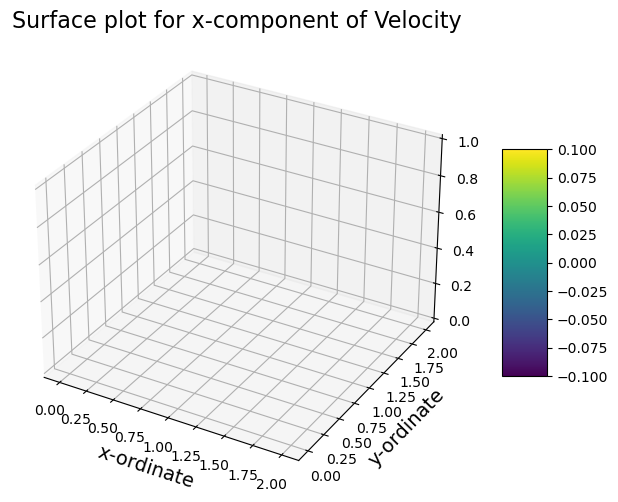

In [23]:
fig = plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes(projection='3d')

surf = ax.plot_surface(x, y, u[20,:,:],cmap='viridis', edgecolor='none')
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title('Surface plot for x-component of Velocity', fontsize = 16)
plt.xlabel('x-ordinate', fontsize = 14)
plt.ylabel('y-ordinate', fontsize = 14)
plt.show()

### Surface Plot for the y-component of the velocity

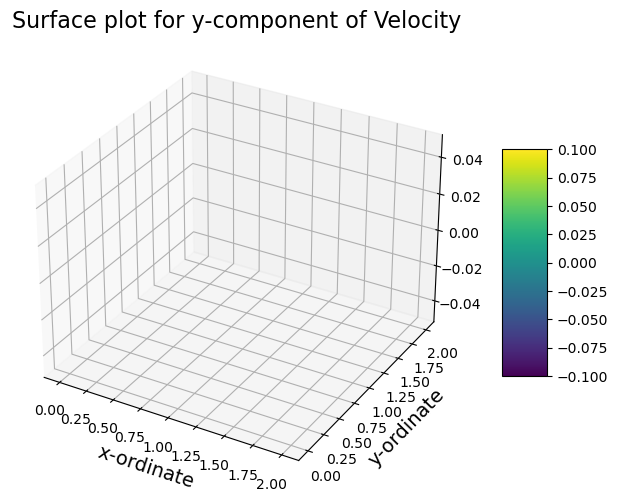

In [24]:
fig = plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes(projection='3d')

surf = ax.plot_surface(x, y, v[20,:,:],cmap='viridis', edgecolor='none')
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title('Surface plot for y-component of Velocity', fontsize = 16)
plt.xlabel('x-ordinate', fontsize = 14)
plt.ylabel('y-ordinate', fontsize = 14)
plt.show()

### Surface Plot for the z-component of the velocity

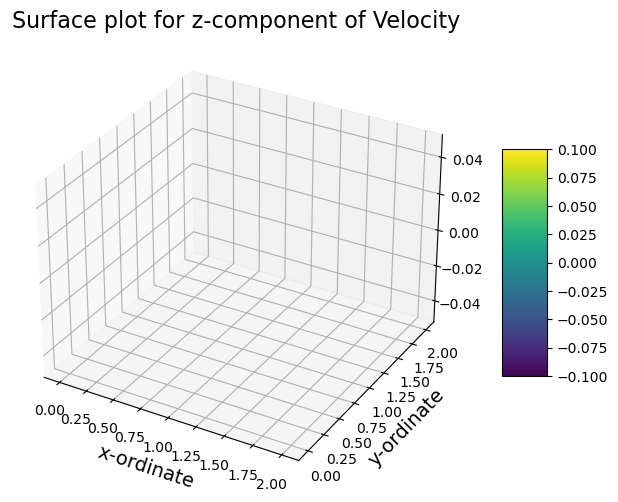

In [25]:
fig = plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes(projection='3d')

surf = ax.plot_surface(x, y, w[20,:,:],cmap='viridis', edgecolor='none')
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title('Surface plot for z-component of Velocity', fontsize = 16)
plt.xlabel('x-ordinate', fontsize = 14)
plt.ylabel('y-ordinate', fontsize = 14)
plt.show()

### Surface Plot of the Velocity Field U

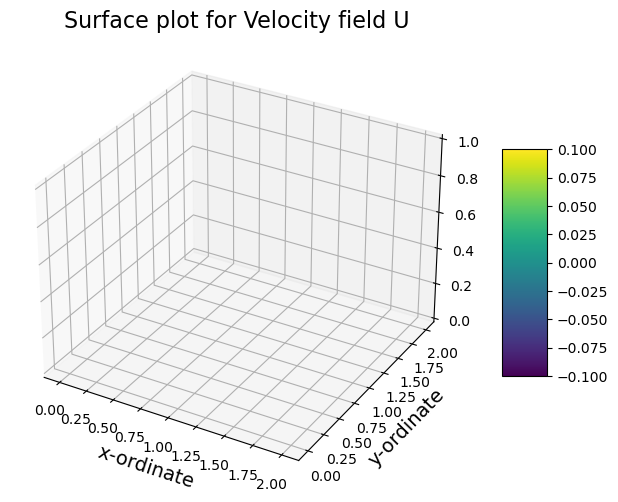

In [26]:
fig = plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes(projection='3d')

surf = ax.plot_surface(x, y, np.sqrt(np.power(u[20,:,:],2)+np.power(v[20,:,:],2)+np.power(w[20,:,:],2)),cmap='viridis', edgecolor='none')
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title('Surface plot for Velocity field U', fontsize = 16)
plt.xlabel('x-ordinate', fontsize = 14)
plt.ylabel('y-ordinate', fontsize = 14)
plt.show()

### Surface Plot of the Pressure P

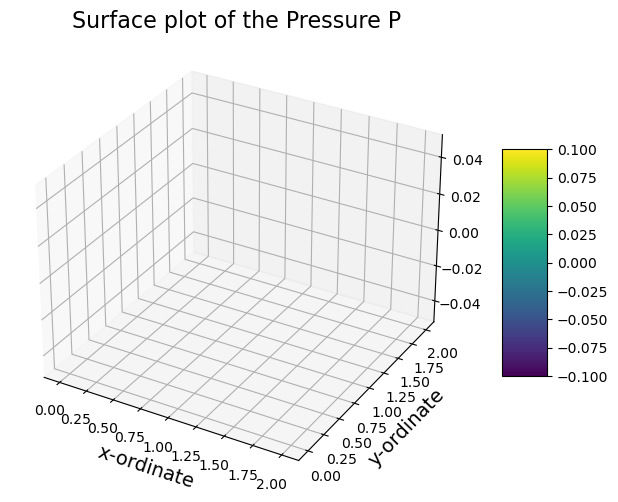

In [27]:
fig = plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes(projection='3d')

surf = ax.plot_surface(x, y, p[20,:,:],cmap='viridis', edgecolor='none')
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title('Surface plot of the Pressure P', fontsize = 16)
plt.xlabel('x-ordinate', fontsize = 14)
plt.ylabel('y-ordinate', fontsize = 14)
plt.show()

In [14]:
u[1,:,:]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., nan, nan, ..., nan, nan,  0.],
       [ 0., nan, nan, ..., nan, nan,  0.],
       ...,
       [ 0., nan, nan, ..., nan, nan,  0.],
       [ 0., nan, nan, ..., nan, nan,  0.],
       [ 0.,  1.,  1., ...,  1.,  1.,  0.]])